<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2025/blob/main/ML_day3/3_1_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.1장

## 예제 2-1. 시각화 예시

### 방한 외국인 수 데이터 시각화

#### 필요한 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기

In [2]:
kor = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.1/data/kor_visit.csv', header=None)
kor = kor.T
kor = kor[2][1:181]
kor.index = pd.date_range(start='1-1-2005', periods=180, freq='ME')
kor = kor.str.replace(',', '').astype(int)
kor

2005-01-31     458321
2005-02-28     477706
2005-03-31     532397
2005-04-30     497955
2005-05-31     475348
               ...   
2019-08-31    1586299
2019-09-30    1459664
2019-10-31    1656195
2019-11-30    1456429
2019-12-31    1456888
Freq: ME, Name: 2, Length: 180, dtype: int64

#### 학습 데이터 분리

In [3]:
kor_up_to_2014 = kor[kor.index <= '2014-12-31']

#### 모델 피팅

In [4]:
model = ExponentialSmoothing(kor_up_to_2014, seasonal='add', seasonal_periods=12).fit()

#### 시뮬레이션 예측

In [5]:
forecast_start_date = '2015-01-01'
forecast_steps = 48  
num_simulations = 100
prediction = model.forecast(steps=forecast_steps)

np.random.seed(2015)
simulated_paths = pd.DataFrame()
residual_std = model.resid.std()
simulated_paths.index = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='ME')

for i in range(num_simulations):
    new_residuals = np.random.normal(0, residual_std, size=forecast_steps)
    simulated_forecast = prediction + new_residuals
    simulated_df = pd.DataFrame({
        f'Visitors_{i}': simulated_forecast,
    })
    simulated_paths = pd.concat([simulated_paths, simulated_df], axis=1)

#### 시각화

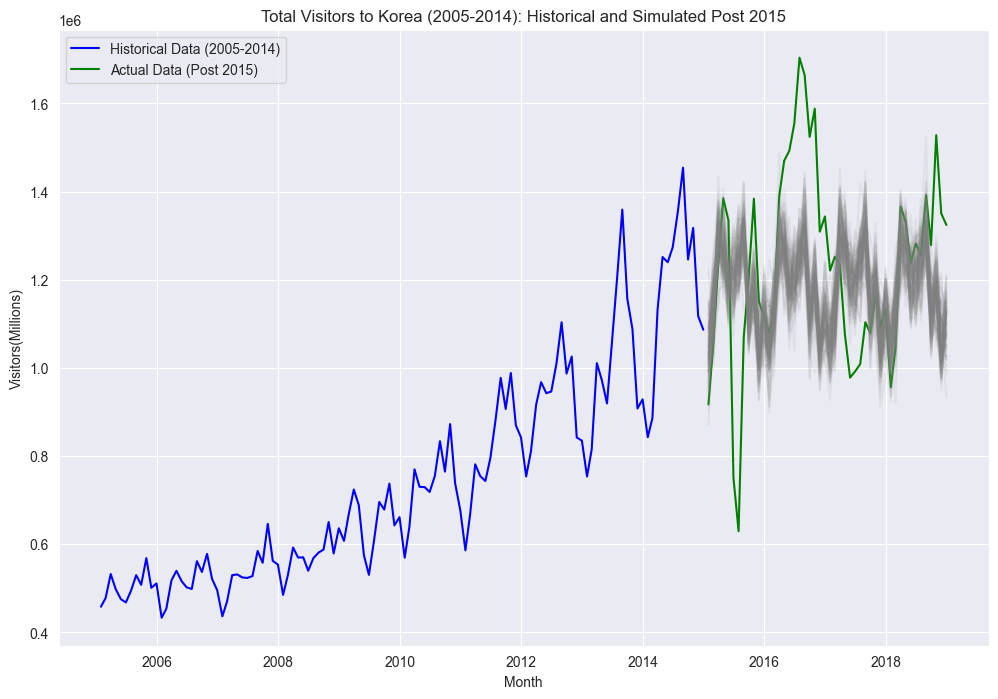

In [6]:
plt.figure(figsize=(12, 8))
kor_filtered = kor[(kor.index >= '2005-01-01') & (kor.index <= '2014-12-31')]
actual_post_2015 = kor[(kor.index > '2014-12-31') & (kor.index <= '2018-12-31')]
plt.plot(kor_filtered, label='Historical Data (2005-2014)', color='blue')
plt.plot(actual_post_2015, label='Actual Data (Post 2015)', color='green')

for i in range(0, num_simulations):
    plt.plot(simulated_paths[f'Visitors_{i}'], color='gray', alpha=0.1)
    
plt.title("Total Visitors to Korea (2005-2014): Historical and Simulated Post 2015")
plt.xlabel("Month")
plt.ylabel("Visitors(Millions)")
plt.legend()
plt.show()

## 예제 2-3. CRPS 계산 예시

### 필요한 패키지 불러오기

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

### 음이항 분포의 밀도 함수 및 누적 함수 생성

In [8]:
r = 10  # 성공 횟수
p = 0.5  # 성공 확률

x = np.arange(0, 50)

pmf = nbinom.pmf(x, r, p)
cdf = nbinom.cdf(x, r, p)

### CRPS 시각화

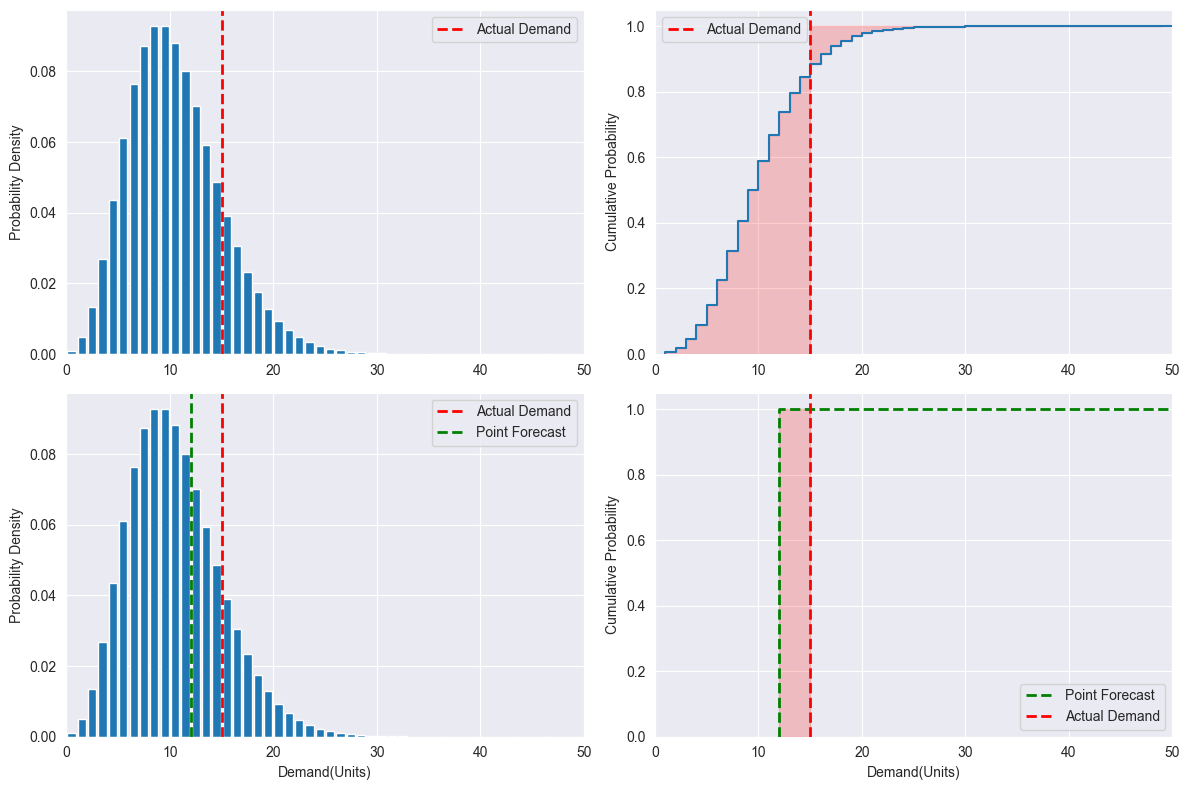

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

axes[0, 0].bar(x+0.5, pmf)
axes[0, 0].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[0, 0].set_ylabel('Probability Density')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 50)
axes[0, 0].set_ylim(0)

axes[0, 1].step(x+1, cdf)
axes[0, 1].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[0, 1].set_ylabel('Cumulative Probability')
axes[0, 1].fill_between(np.arange(1, 16), 0, cdf[:15], step="pre", color='red', alpha=.2)
axes[0, 1].fill_between(np.arange(15, 50), 1, cdf[14:49], step="pre", color='red', alpha=.2)
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 50)
axes[0, 1].set_ylim(0)

axes[1, 0].bar(x+0.5, pmf)
axes[1, 0].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[1, 0].axvline(x=12, color="green", linestyle="--", linewidth=2, label="Point Forecast")
axes[1, 0].set_ylabel('Probability Density')
axes[1, 0].set_xlabel('Demand(Units)')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 50)
axes[1, 0].set_ylim(0)

axes[1, 1].step([12,13,50], [0,1,1], linestyle="--", color="green", linewidth=2, label="Point Forecast")
axes[1, 1].axvline(x=15, color="red", linestyle="--", linewidth=2, label="Actual Demand")
axes[1, 1].fill_between(np.arange(12, 16), 0, 1, step="pre", color='red', alpha=.2)
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_xlabel('Demand(Units)')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 50)
axes[1, 1].set_ylim(0)

plt.tight_layout()
plt.show()

## 예제 2-4.  확률적 예측 예시

### 방한 외국인 수의 확률적 예측 

### 필요한 패키지 불러오기

In [10]:
import matplotlib.pyplot as plt
import numpy as np

### 데이터 불러오기

In [11]:
kor = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.1/data/kor_visit.csv', header=None)
kor = kor.T
kor = kor[2][1:181]
kor.index = pd.date_range(start='1-1-2005', periods=180, freq='ME')
kor = kor.str.replace(',', '').astype(int)

### 확률적 예측

In [12]:
rolling_window = 12 
median_forecast = kor.rolling(window=rolling_window).median()
p90_forecast = kor.rolling(window=rolling_window).quantile(0.9)
p10_forecast = kor.rolling(window=rolling_window).quantile(0.1)

### 데이터 시각화

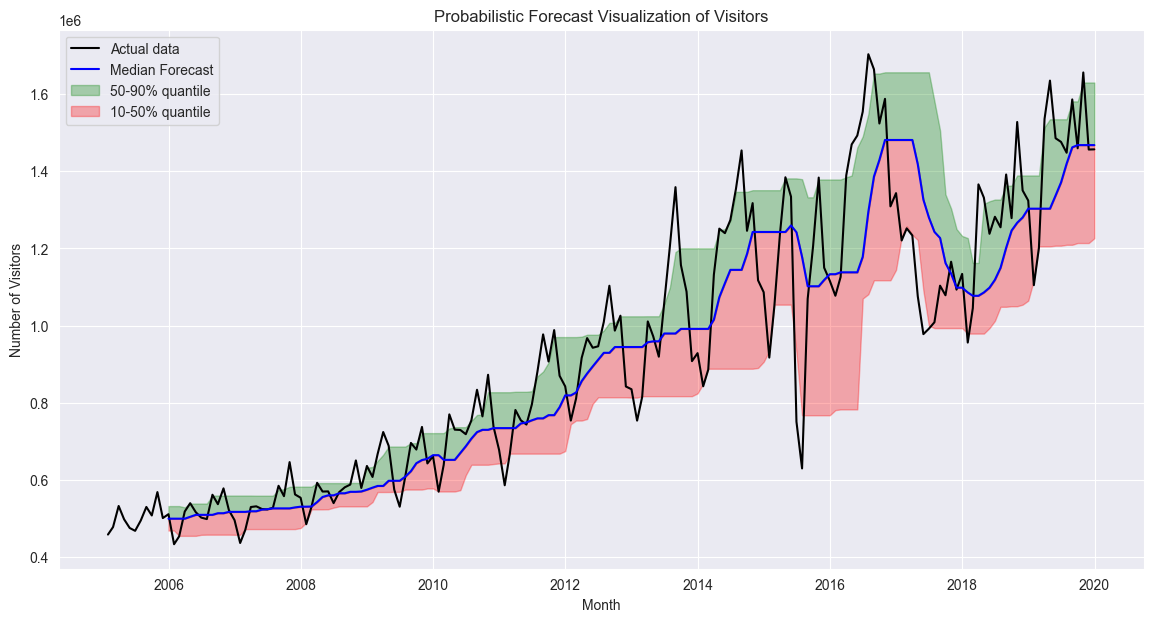

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(kor, label='Actual data_mon', color='black')
plt.plot(kor.index, median_forecast, label='Median Forecast', color='blue')
plt.fill_between(kor.index, median_forecast, p90_forecast, color='green', alpha=0.3, label='50-90% quantile')
plt.fill_between(kor.index, median_forecast, p10_forecast, color='red', alpha=0.3, label='10-50% quantile')

plt.grid(True)
plt.title('Probabilistic Forecast Visualization of Visitors')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()